# Introduction -- Reminder

Each Python lab will start with a pre-flight exercise that walks through building some of the set up and tools ($\sim$ 30 min), followed by an in-class tutorial with time for Q+A (50 min) so you can walk through steps that will be necessary for the homework assignment you will submit ($\sim$ 3 hrs).  Each lab will contain starter code, similar to what you see below.  Please fill in the code to complete the pre-flight assignment in preparation for the in-class tutorial.  

Preflight ($\sim$30-60 min, 10 points) **Typically due: Wednesdays 3pm EST**

*Preflight typically graded by Wednesday 5p EST*

In-class tutorial and Q+A ($\sim$ 50 min, 10 points) **Typically occurs: Thursdays 9am EST**

Homework assignment ($\sim$ 3-5 hrs, 30 points) **Typically due: Mondays 9am EST** 

*Homework typically graded by Thursday 5p*

When we grade your homework, we will not run your code. Once submitted, your notebook should have the outputs for all of your results.  Please do not include long outputs from debugging, beyond a few print statements and the requested visualizations (i.e. plots).

**Grading:** When we grade your notebook, we will convert the .ipynb file to an HTML file.  We will be using [nbgrader](https://nbgrader.readthedocs.io/en/stable/) to grade your notebooks.  **Note:** If your ```IPython``` version is too old, we will *not* be able to grade your assignments.


# Phys 260 Python Tutorial/HW 8: Integrating the Biot-Savart Law  (30 points total)

## Tutorial Summary
- Brief re-review of the Biot-Savart law and the corresponding functions
- Mutliple line wires

In [3]:
import numpy as np
from matplotlib import pyplot as plt

## Brief Review of the Biot-Savart Law

The <b>Biot-Savart Law</b> describes how currents produce magnetic fields: 
\begin{equation}
       \mathbf{B}(\vec{r}) = \frac{\mu_0}{4\pi}\int\frac{I\,d\vec{\ell}\times ({\vec{r}-\vec{r}^{\prime})}}{|r-r^\prime|^3}
\end{equation}
In this expression, $\vec{r}$ is a field point (we use a `np.meshgrid` to sample field points), and the integral runs over all the currents, whose positions are labeled by the vector $\vec{r}^\prime$.  Recall, when discretized for numerical calculations, integrals act as sums.

The field point $\vec{r}$ is fixed for a particular integration (sum). In general, this integral is difficult to evaluate analytically. This is why most introductory courses, like Phys260, typically restrict to examples with symmetries, like infinite straight wires, or the axis of symmetry of a loop. Computers have no such limitations, as we can sample over any configuration, regardless of symmetry (recall how we calculated the electric field due to a rectangular prism of charge).

Steps of simulating the magnetic field:
- Identify field points you wish to sample for visualization 
- Discretize the current-containing wire configuration
- Apply the numerical version of the Biot-Savart Law
- Visualize

### Functions that build the Biot-Savart Law (Group talk through - 10min)

Below is a function `calculate_magnetic_field_at_point`, the numerical calculation of the integrand in the Biot-Savart Law.  This is the magnetic field contribution due to a given current element to a single point in the field r,

\begin{equation}
d\vec{B}(\vec{r})=\frac{\mu_0}{4\pi} \frac{I\,d\vec{l}\times ({\vec{r}-\vec{r}^{\prime})}}{|r-r^\prime|^3}
\end{equation}

We can apply this function to *all* points we are sampling in our field with `np.apply_along_axis`, which is wrapped by the function `calculate_bfield_on_grid`.  

We can then account for all current elements and sum, and do this in `calculate_bfield_from_current_elements`.  This is effectively doing the integral (but quantizing as a sum),
\begin{eqnarray}
\vec{B}(\vec{r}) &=& \int d\vec{B}(\vec{r})\\
&=&\frac{\mu_0}{4\pi} \int\frac{I\,d\vec{l}\times ({\vec{r}-\vec{r}^{\prime})}}{|r-r^\prime|^3}\\
&\approx&\frac{\mu_0}{4\pi} \sum_i I\frac{\Delta \vec{l_i}\times ({\vec{r}-\vec{r_i}^{\prime})}}{|r-r_i^\prime|^3}
\end{eqnarray}
where we have individual pieces of the wire, $\Delta \vec{l_i}$, at position $\vec{r_i}^{\prime}$, and we have to sum up all of the quantized contributions.  You will notice the explicit accounting of the $\Delta l_i$ as an argument below.  Note, we are still setting constants out in front to 1 to keep plotted numbers simple.  If we assume constant current I throughout a single connected wire element, we can factor that out as well (and for simplicity set this to 1).  

In [4]:
def calculate_magnetic_field_at_point(field_position, current_position, current_method, dl) :
    '''Calculates magnetic field at point due to current vector element at a given position
    Parameters
    ----------
    field_position : n-darray
        position of field element
    current_position : n-darray
        position of current element
    current_method : func
        callable that returns the current at a position
    dl : float
        length of wire segment, delta l
    
    '''
    idl = current_method(current_position, dl)
    r = field_position - current_position
    r_magnitude = np.linalg.norm(r)
    return np.cross(idl, r) / r_magnitude**3


def calculate_bfield_on_grid(current_position, field_positions, current_method, dl) :
    """ Find the bfield on a grid of field points due to a single current element.

    Inputs:
    current_position (n-darray) : x, y, and z position for charge, shape (3,) 
    field_positions (n-darray) : x, y, and z positions for field points, shape (3,l,m,n)
    current_method (func) : callable to return the current element at current_position
    dl (float) : length of wire segment, delta l
    
    Outputs:
    vector_bfield (n-darray) : x, y, z components of the b-field at the point field_position, shape (3,l,m,n) 

    """
    assert(current_position.shape[0]==3)
    assert(field_positions.shape[0]==3)
    return np.apply_along_axis(calculate_magnetic_field_at_point, 0, 
                                field_positions, current_position, current_method, dl)

def calculate_bfield_from_current_elements(current_positions, field_positions, current_method, dl) : 
    """ 
     Find the bfield on a grid of field points due to a single charge.

    Inputs:
    current_positions (n-darray) : x, y, and z position for charge, shape (3,n,m,l) 
    field_positions (n-darray) : x, y, and z positions for field points, shape (3,i,j,k)
    current_method (func) : callable to return the current element at single current_position
    dl (float) : length of wire segment, delta l

    Outputs:
    vector_bfield (n-darray) : x, y, z components of the b-field at the point field_position, shape (3,i,j,k)
    
    """
    assert(current_positions.shape[0] == 3)
    bfield_vectors_along_axis = np.apply_along_axis(calculate_bfield_on_grid, 0, 
                                                    current_positions, 
                                                    field_positions, current_method, dl)
    print('bfield vectors not summed shape: ',bfield_vectors_along_axis.shape)
    print('with size: ', bfield_vectors_along_axis.size)
    summed_bfield = bfield_vectors_along_axis.sum(axis=(4,5,6))
    print('summed along fourth axis, bfield vectors shape: ', summed_bfield.shape)
    print('with size: ', summed_bfield.size)
    return summed_bfield

We will talk about dealing with the extra two axes shortly - the reason these got picked up has to do with the fact that the current positions are a (3,m,n,l) array.  If we raveled these such that they were a (3,n,n,n) array, we would not need to do this.

**Quick question for class**: What is the dl for the points sampling the current below (`test_current_positions`)?

In [5]:
# Testing out the functions with similar set ups to the pre-flight
test_current_positions = np.array(np.meshgrid(np.linspace(-5,5,100), 
                                              np.array([0]), 
                                              np.array([0]), 
                                              indexing='ij')) # line wire
print('current positions shape: ',test_current_positions.shape)

test_field_positions = np.array(np.meshgrid(np.array([0]),
                                            np.linspace(-1,1,5),
                                            np.linspace(-1,1,5),
                                            indexing='ij' )) # 25 points on yz plane
print('field positions shape: ',test_field_positions.shape)

def test_current_method(current_position, dl) :
    return np.array([1,0,0]) * dl

test_bfield = calculate_bfield_from_current_elements(test_current_positions, 
                                                     test_field_positions, 
                                                     test_current_method, dl=.1)
print('bfield shape: ',test_bfield.shape)
print('with size: ',test_bfield.size)

current positions shape:  (3, 100, 1, 1)
field positions shape:  (3, 1, 5, 5)
bfield vectors not summed shape:  (3, 1, 5, 5, 100, 1, 1)
with size:  7500
summed along fourth axis, bfield vectors shape:  (3, 1, 5, 5)
with size:  75
bfield shape:  (3, 1, 5, 5)
with size:  75


For more details on "collapsing along axes" and visuals of n-darrays, I recommend taking a look at [this link](https://www.youtube.com/watch?v=nS0oKBbNjWY) from the preflight.  

The simplest example analogy to what we did in the last step (getting the summed bfield with shape (3,1,5,5,1,1) down to a (3,1,5,5) array while keeping all 300 elements) is the following:

In [6]:
# Example of array slicing with axis shape 1.

arr1 = np.array([0,1]) 
arr2 = np.array([[0],[1]]) #  This is almost the same as arr1, but has a second dimension
sliced_arr2 = arr2[:,0]


print('arr1 is similar to a vector: \n', arr1)
print('with shape: ',arr1.shape)
print('arr2 is similar to a 2x1 matrix (two rows, 1 column): \n', arr2)
print('with shape: ', arr2.shape)
print('The first column of arr1 is like the arr1 vector')
print(sliced_arr2.shape)
print('This assertion shows that arr1 and arr2[:,0] are equivalent')
assert((arr1 == sliced_arr2).all())

arr1 is similar to a vector: 
 [0 1]
with shape:  (2,)
arr2 is similar to a 2x1 matrix (two rows, 1 column): 
 [[0]
 [1]]
with shape:  (2, 1)
The first column of arr1 is like the arr1 vector
(2,)
This assertion shows that arr1 and arr2[:,0] are equivalent


**Short Essay Question (Take home -- 3 points)**: 
- Explain (in full sentences), the difference between `arr1` and `arr2`, despite the fact that they have the same "size", or number of elements.  
- How does this extend to the B-field example before?
- How might you extend this description to ndarray objects with shape (2,2) and (2,2,1)?

You may find the visual from this [blog post](https://medium.com/mlait/tensors-representation-of-data-in-neural-networks-bbe8a711b93b) useful -- the further details in this post are specific to another python library called tensorflow.

- The first, `arr1`, is like a length 2 vector.  On the other hand, `arr2` is like a 1-column matrix with two rows.  The first column of `arr2` corresponds exactly to `arr1`.  This is how the elements (size) are the same, but the shapes differ. 
- In the B-field example, the `axis=4` and `axis=5` indicate that it is the extended version of a 1-column matrix along each of those axes.  We can slice the `[0]` element along each to keep all elements, but have teh same shape as the input field points array.
- For a (2,2) object, we can consider this a matrix with two columns and two rows. This is also the 0th component of a (2,2,1) rank 3 tensor.

### The crux of the simulating the magnetic field for different (uniform) current configurations

Now that we have functions to calculate the magnetic field at any point due to a current carrying wire configuration, the remaining steps are to:
- Define `field_positions`, the output of a numpy meshgrid, in planes that are informative to us (you can do the calculation on a meshgrid sampling 3-dimensional space, but can add up to a lot of points and you'll only ever need to examine the field in a given slice),
- Define the points sampling the current, `current_positions`, potentially an output of a numpy meshgrid, or simply collected coordinates,
- Define a function that outputs the vector corresponding to the current sampled, `current_method`.

**Note**: Depending on how many "pieces" we break a current-carrying wire into, we'll have to account for this with the dl.  e.g. A loop wire that we quantize into 20 pieces, or that is sampled by 20 equally spaced points, will have a $d\vec{l}$ of length $2\pi R$/20.  Then, we would add up all 20 contributions to each field point.

### Define field positions (4 points -- in groups 5 min)

In the cell below, define `xy_plane_points` and `yz_plane_points` using `np.meshgrid`, indexing with 'ij'.  There is an analogous example above when we defined test_field_points.  The field positions you define should respectively sample a square plane of points where $z=0$ and $x=0$.  Sample 10 points across in a square of side length 4 (between -2 and 2), so you have a total of 100 points sampled on each plane.  Take a look at the assertion statements in the next cell over - do those shapes make sense to you?

In [7]:
### BEGIN SOLUTION
xy_plane_points = np.array(np.meshgrid( np.linspace(-2,2,10),
                                         np.linspace(-2,2,10),
                                            np.array([0]),
                                            indexing='ij' ))
yz_plane_points = np.array(np.meshgrid( np.array([0]),
                                           np.linspace(-2,2,10),
                                             np.linspace(-2,2,10),
                                                indexing='ij' ))
### END SOLUTION

In [8]:
"""Execute to check you're on the right track"""
assert(xy_plane_points.shape == (3,10,10,1))
assert(yz_plane_points.shape == (3,1,10,10))

### Define wire positions (4 points -- in groups 5 min)

For the preflight, we defined wire positions for a line wire, `points_of_linewire`, where the linewire ran along the x-axis.  One possible solution to sample a current with this configuration with 100 sampled points is,

```
xarray, yarray, zarray = np.meshgrid(np.linspace(-5,5,100),
                                    np.array([0]),
                                    np.array([0]), indexing='ij')
points_of_linewire = np.array([xarray, yarray, zarray])
```

In the cell below, define sampled positions for two line wires, `parallel_points_linewires`, where we have two linewires running parallel to the x-axis, one at $y=0.5m$, the other at $y=-0.5m$.  The shape of `parallel_points_linewires` should show that the first axis (zeroeth) has 3 elements across, corresponding to the x, y, and z coordinates of each point sampling the wires.

You may find the `np.concatenate` method useful here.

In [9]:
# Define parallel_points_linewires here

### BEGIN SOLUTION
xtop, ytop, ztop = np.meshgrid(np.linspace(-5,5,100),
                                    np.array([.5]),
                                    np.array([0]), indexing='ij')

xbot, ybot, zbot = np.meshgrid(np.linspace(-5,5,100),
                                    np.array([-.5]),
                                    np.array([0]), indexing='ij')

parallel_points_linewires = np.array([np.concatenate([xtop,xbot]), 
                                      np.concatenate([ytop,ybot]),
                                      np.concatenate([ztop,zbot])])
### END SOLUTION

In [10]:
"""Execute to check you're on the right track"""
assert(parallel_points_linewires.shape[0] == 3)
assert(parallel_points_linewires[0].min() == -5)
assert(parallel_points_linewires[1].min() == -0.5)
assert(parallel_points_linewires[1].max() == 0.5)
assert((parallel_points_linewires[2] == 0).all())

### Define a method to determine current (4 points -- in groups 5 min)

Let us now define a method for anti-parallel wires.  We want the current to point in the "+x" direction in the wire above the zx-plane (y=0.5), and in the "-x" direction in the wire below the zx-plane (y=-0.5).  **Quick question for the class before break out:** What should the type of the returned quantity be (fill out the docstring)?

In [11]:
def anti_parallel_xwires(current_position, dl) :
    """Returns the Id\vec{l} of a wire running parallel to the x-axis, 
    with positive current above the zx-plane, negative below.    

    Inputs:
    current_position (3, n-darray) : x, y, and z position for current element 

    Outputs:
    FILL OUT DOCSTRING HERE
    """
    ### BEGIN SOLUTION
    if current_position[1] > 0 :
        return np.array([1,0,0]) * dl
    else :
        return np.array([-1,0,0]) * dl
    ### END SOLUTION

In [12]:
"""Execute to check you're on the right track"""
assert((anti_parallel_xwires(np.array([1,1,0]), .1) == np.array([.1,0,0])).all())
assert((anti_parallel_xwires(np.array([-1,-1,0]), .1) == np.array([-.1,0,0])).all())

### Let's visualize the system (in class discussion/work together -- 5 points total)

**Quick question for class:**  What slice (plane) of field space should we visualize that might be interesting for two anti-parallel wires?

We will talk through using `calculate_bfield_from_current_elements` to define `bfield_slice_antiparallel` below.

In [13]:
# Calculate the b-field on that slice due to antiparallel wires
### BEGIN SOLUTION
bfield_slice_antiparallel = calculate_bfield_from_current_elements(parallel_points_linewires, 
                                                                     yz_plane_points, 
                                                                     anti_parallel_xwires, dl=.1)
### END SOLUTION

bfield vectors not summed shape:  (3, 1, 10, 10, 200, 1, 1)
with size:  60000
summed along fourth axis, bfield vectors shape:  (3, 1, 10, 10)
with size:  300


In [14]:
"""Execute to check you're on the right track"""
assert(bfield_slice_antiparallel.shape[0] == 3)

**Visualize (2 points):** How might you indicate the direction of the current in the figure below?  Add a useful visual (see example with 'x' and 'o' from the preflight).

(1, 10, 10)
color shape:  (10, 10)
yz_plane_points shape:  (3, 1, 10, 10)
bfield shape:  (3, 1, 10, 10)


Text(0,0.5,'y')

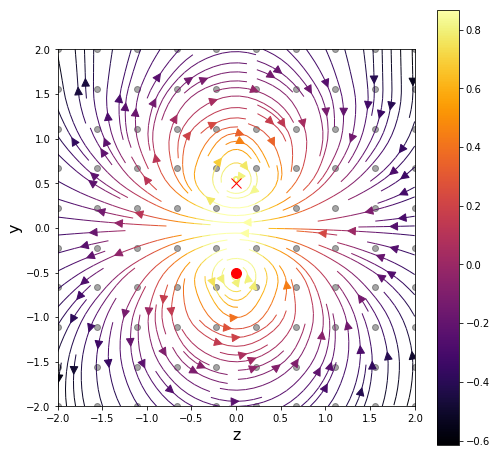

In [15]:
fig, ax1 = plt.subplots(1, figsize=(8,8))
magnitude_b_field = np.linalg.norm(bfield_slice_antiparallel,axis=0)
print(magnitude_b_field.shape)

color = np.log10(magnitude_b_field[0] )   # colors the arrows based on field strength
print('color shape: ', color.shape)
print('yz_plane_points shape: ', yz_plane_points.shape)
z_points_at_constant_x = yz_plane_points[2,0,:,:]
y_points_at_constant_x = yz_plane_points[1,0,:,:]

print('bfield shape: ', bfield_slice_antiparallel.shape)
z_component_bfield = bfield_slice_antiparallel[2,0,:,:]
y_component_bfield = bfield_slice_antiparallel[1,0,:,:]

strm=ax1.streamplot(z_points_at_constant_x, y_points_at_constant_x, z_component_bfield, y_component_bfield, color=color, linewidth=1, 
               cmap=plt.cm.inferno, density=1.5, arrowstyle='simple', arrowsize=1.5)

plt.scatter(y_points_at_constant_x, z_points_at_constant_x, c='k', alpha=0.35) # Field points sampled

### BEGIN SOLUTION
ax1.plot(0,.5,'x', markersize=10, color='r')   # indicate the location of the wire
ax1.plot(0,-.5,'o', markersize=10, color='r')   # indicate the location of the wire
### END SOLUTION

fig.colorbar(strm.lines)

ax1.set_aspect('equal')
ax1.set_xlim([-2,2])
ax1.set_ylim([-2,2])
ax1.set_xlabel('z', fontsize=16)
ax1.set_ylabel('y', fontsize=16)

**Discuss the plot (Take home)**:  Does this figure make sense?  Make sure to add an "x" and an "o" symbol corresponding to current going into and out of the page at the appropriate location.  Why does this make sense?

We see the field lines wrap and obey the right hand rule around each wire.  The magnetic field goes clockwise above, and counter-clockwise below.  In between the wires, the field lines add.

## Homework Summary (10 points)
- Mutliple line wires (add three above and three below the zx-plane) -- need to define the `current_positions` array corresponding to `four_parallel_points_linewires`
- Multiple line wires with parallel current -- need to define a new (but very similar to `anti_parallel_xwires`) function called `parallel_xwires`. 
- A loop wire -- need to use new `np` tools, `np.cos` and `np.sin` to define the $d\vec{l}$ in the function for current, also need to sample points around a circle to define the loop wire positions.
- Multiple loop wires -- analogs from all of the above

### Four wires above and below the zx-plane (2 points)

In the cell below, define `four_parallel_points_linewires` all running parallel to the x-axis.  The first four should sample four parallel wires at $y=0.5$, at equidistant z-values between $-1<z<1$ and four parallel wires at $y=-0.5$, at the same equidistant z-values.  This is an extension of `parallel_points_linewires`. I recommend defining a list of your wire's z-values, `zvalues`, and using this both in defining the points in the linewires and also in marking the "x"'s and "o"'s of your streamplot figure.

In [16]:
# Define four_parallel_points_linewires here

### BEGIN SOLUTION
zvalues = [-.8,-.4,0,.4]
xtop, ytop, ztop = np.meshgrid(np.linspace(-5,5,100),
                                    np.array([.5]),
                                    np.array(zvalues), indexing='ij')

xbot, ybot, zbot = np.meshgrid(np.linspace(-5,5,100),
                                    np.array([-.5]),
                                    np.array(zvalues), indexing='ij')

four_parallel_points_linewires = np.array([np.concatenate([xtop,xbot]), 
                                      np.concatenate([ytop,ybot]),
                                      np.concatenate([ztop,zbot])])
### END SOLUTION

In [17]:
"""Execute to check you're on the right track"""
assert(four_parallel_points_linewires.shape[0]==3)
assert(four_parallel_points_linewires[1].max() == 0.5)
assert(four_parallel_points_linewires[1].min() == -0.5)

Plot the magnetic field in the yz-slice for the antiparallel current case.  I recommend adding the appropriate "x"'s and "o"'s.  Do you see what the magnetic field behavior might look like if we had, instead, sheets of antiparallel current?  You can experiment with: 
- yz plane points further towards the ends of the wires (e.g. $x\approx5$ where you see the edge effects of our discretization (these are not truly infinitely long wires),
- moving the wires closer together to see what happens when they sit at $y=\pm 0.25$ (move them back before submitting, otherwise the assertion cell will fail)
- Note: Leave a figure with the original prompt's configuration that illustrates the B-field in the previously defined `yz_plane_points`. 

bfield vectors not summed shape:  (3, 1, 10, 10, 200, 1, 4)
with size:  240000
summed along fourth axis, bfield vectors shape:  (3, 1, 10, 10)
with size:  300
(1, 10, 10)
(10, 10)


Text(0,0.5,'y')

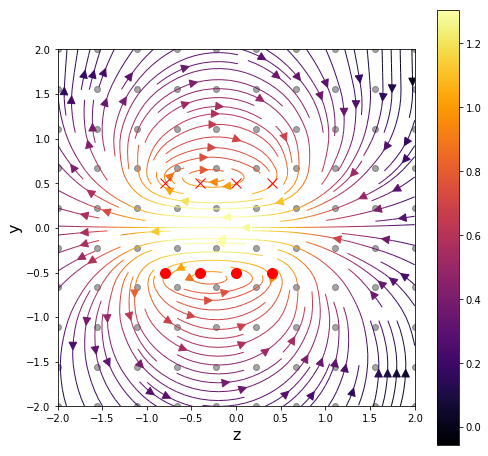

In [18]:
### BEGIN SOLUTION
bfield_slice_antiparallel_sheets = calculate_bfield_from_current_elements(four_parallel_points_linewires, 
                                                                         yz_plane_points, 
                                                                         anti_parallel_xwires, dl=.1)

fig, ax1 = plt.subplots(1, figsize=(8,8))
magnitude_b_field = np.linalg.norm(bfield_slice_antiparallel_sheets,axis=0)
print(magnitude_b_field.shape)

color = np.log10(magnitude_b_field[0] )   # colors the arrows based on field strength

print(color.shape)

z_points_at_constant_x = yz_plane_points[2,0,:,:]
y_points_at_constant_x = yz_plane_points[1,0,:,:]

z_component_bfield = bfield_slice_antiparallel_sheets[2,0,:,:]
y_component_bfield = bfield_slice_antiparallel_sheets[1,0,:,:]

strm=ax1.streamplot(z_points_at_constant_x, y_points_at_constant_x, z_component_bfield, y_component_bfield, color=color, linewidth=1, 
               cmap=plt.cm.inferno, density=1.5, arrowstyle='simple', arrowsize=1.5)

plt.scatter(y_points_at_constant_x, z_points_at_constant_x, c='k', alpha=0.35) # Field points sampled

for zwire in zvalues :
    ax1.plot(zwire,.5,'x', markersize=10, color='r')   # indicate the location of the wire
for zwire in zvalues :
    ax1.plot(zwire,-.5,'o', markersize=10, color='r')   # indicate the location of the wire

fig.colorbar(strm.lines)

ax1.set_aspect('equal')
ax1.set_xlim([-2,2])
ax1.set_ylim([-2,2])
ax1.set_xlabel('z', fontsize=16)
ax1.set_ylabel('y', fontsize=16)
### END SOLUTION

### Parallel current with the same wire configuration (2 points)

In the cell below, define a function `parallel_xwires` such that all current runs in the "+x" direction. 

In [19]:
### BEGIN SOLUTION
def parallel_xwires(current_position, dl) :
    """Returns the Id\vec{l} of a wire running parallel to the x-axis, 
    with positive current.    

    Inputs:
    current_position (3, n-darray) : x, y, and z position for current element 

    Outputs:
    idl (3, n-darray) : id\vec{l} x, y, and z component of the differential current element
    """
    return np.array([1,0,0]) * dl
### END SOLUTION

In [20]:
"""Execute to check you're on the right track"""
assert((parallel_xwires(np.array([1,1,0]), .1) == np.array([.1,0,0])).all())
assert((parallel_xwires(np.array([-1,-1,0]), .1) == np.array([.1,0,0])).all())

Plot the magnetic field in the yz-slice for the parallel current case.  You should indicate current all going in the same direction with either"x"'s and "o"'s (what is appropriate?).  Do you see what the magnetic field behavior might look like if we had, instead, sheets of parallel current?  You can experiment with: 
- yz plane points further towards the ends of the wires (e.g. $x\approx5$ where you see the edge effects of our discretization (these are not truly infinitely long wires),
- moving the wires closer together to see what happens when they sit at $y=\pm 0.25$ (move them back before submitting, otherwise the assertion cell will fail)
- adding yet another wire on the top and bottom 
- Note: Leave a figure with the original prompt's configuration that illustrates the B-field in the previously defined `yz_plane_points`. 

bfield vectors not summed shape:  (3, 1, 10, 10, 200, 1, 4)
with size:  240000
summed along fourth axis, bfield vectors shape:  (3, 1, 10, 10)
with size:  300
(1, 10, 10)
(10, 10)


Text(0,0.5,'y')

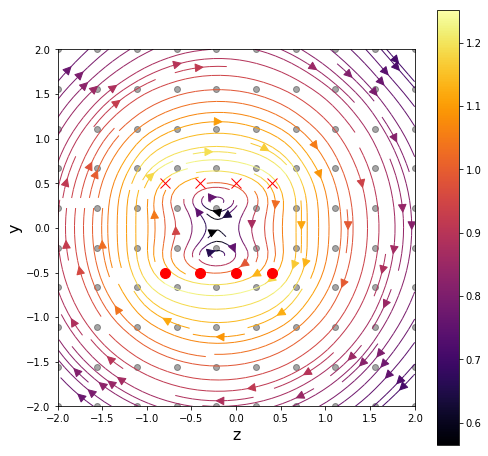

In [21]:
### BEGIN SOLUTION
bfield_slice_parallel_sheets = calculate_bfield_from_current_elements(four_parallel_points_linewires, 
                                                                         yz_plane_points, 
                                                                         parallel_xwires, dl=.1)

fig, ax1 = plt.subplots(1, figsize=(8,8))
magnitude_b_field = np.linalg.norm(bfield_slice_parallel_sheets,axis=0)
print(magnitude_b_field.shape)

color = np.log10(magnitude_b_field[0] )   # colors the arrows based on field strength

print(color.shape)

z_points_at_constant_x = yz_plane_points[2,0,:,:]
y_points_at_constant_x = yz_plane_points[1,0,:,:]

z_component_bfield = bfield_slice_parallel_sheets[2,0,:,:]
y_component_bfield = bfield_slice_parallel_sheets[1,0,:,:]

strm=ax1.streamplot(z_points_at_constant_x, y_points_at_constant_x, z_component_bfield, y_component_bfield, color=color, linewidth=1, 
               cmap=plt.cm.inferno, density=1.5, arrowstyle='simple', arrowsize=1.5)

plt.scatter(y_points_at_constant_x, z_points_at_constant_x, c='k', alpha=0.35) # Field points sampled

for zwire in zvalues :
    ax1.plot(zwire,.5,'x', markersize=10, color='r')   # indicate the location of the wire
for zwire in zvalues :
    ax1.plot(zwire,-.5,'o', markersize=10, color='r')   # indicate the location of the wire

fig.colorbar(strm.lines)

ax1.set_aspect('equal')
ax1.set_xlim([-2,2])
ax1.set_ylim([-2,2])
ax1.set_xlabel('z', fontsize=16)
ax1.set_ylabel('y', fontsize=16)
### END SOLUTION

**Discuss the limit of current sheets (1 point)**: In the cell below, describe what you see happening and what the limit of the behavior will be as you add more and more wires in each case.  The addition of more and more wires approaches two sheets of current as you saw in class.  

In the limit of sheets, the anti-parallel case has magnetic field lines that add in between (pointing in the negative z direction) and cancel out outside.  The parallel case is the reverse, with the magnetic field in between cancelling, and the magnetic field outside adding, in the "+z" direction at positive y and "-z" direction and negative y.

### A loop wire (2 points) 

Defining both the wire positions and $\Delta \vec{l}$ is a bit trickier here because you are dealing with a circle.  The following text should walk you through this construction.  

Consider a circle on the xy-plane (constant z, say $z=0$), with current flowing clockwise (so with increasing $\phi$).  With the line wire, we varied over x, so $d\vec{l}=dx\hat{x}$, coded with `dl*np.array([1,0,0])`.  This problem has cylindrical symmetry, so we will work in cylindrical coordinates, ($r,\phi,z$), and our $d\vec{l}$ will vary with our $d\phi\hat{\phi}$. 

For a circle with radius R (circumference $S=2\pi R$), quantized into n arclets of length $\Delta s=2\pi R/n$ at each $\phi_i$ (where $1\leq i\leq n$ so $\Delta\phi/2\pi=1/n$, we have a corresponding $d\vec{l}$ of,
\begin{eqnarray}
d\vec{l}&=&dl\hat{\phi}\\
&=&Sd\phi\hat{\phi}\\
&\approx&S\frac{\Delta\phi}{2\pi}\hat{\phi}\\
&=&\Delta s\hat{\phi}\\
&=&\frac{2\pi R}{n}\hat{\phi}\\
\end{eqnarray}
namely the arclength times the unit vector tangent to the circle.  So, for the ith segment,
\begin{eqnarray}
\Delta\vec{l}_i&=&\frac{2\pi R}{n}\hat{\phi_i}
\end{eqnarray}
The conversion of $\hat{\phi}$ to cartesian coordinates will depend on the value of $\phi_i$ corresponding to the sampled position in the loop.  If you have not yet seen the conversions between unit vectors, the [wiki page](https://en.wikipedia.org/wiki/Del_in_cylindrical_and_spherical_coordinates) is fairly comprehensive, but remember to swap $\theta\leftrightarrow\phi$ to go between math $\leftrightarrow$ physics norms.
\begin{eqnarray}
\hat{\phi}_i&=&-\sin\phi_i\hat{x}+\cos\phi_i\hat{y}\\
&=&\frac{-y\hat{x}+x\hat{y}}{R}\\
\end{eqnarray}
The positions of points sampled in the loop, ($x_i,y_i,z$), correspond to the individual $\phi_i$'s (where $1\leq i\leq n)$, and these are,
\begin{eqnarray}
x_i&=&R\cos\phi_i\\
y_i&=&R\sin\phi_i
\end{eqnarray}

In the cell below, define both the numpy array that samples `points_in_loop` and the function, `clockwise_loop_wire_xy`, that returns your $d\vec{l}$ for a given point in a loop parallel to the xy-plane with current running clockwise.  Assume a radius of $R=1m$ to again, keep numbers simple and reduce a proliferation of constants out in front.  It may be useful to know that numpy has both [`np.cos`](https://numpy.org/doc/stable/reference/generated/numpy.cos.html) and [`np.sin`](https://numpy.org/doc/stable/reference/generated/numpy.sin.html) functions, which do expect angles in radians.  

I suggest you first quantize sampled values of $\phi$ in the same manner we quantized sampled values of $x$ in the line wire example (make sure to *not* double count 0 and $2\pi$).  If you use `np.linspace`, there is a key word argument `endpoint` that is useful.

In [46]:
# Define the numpy array points_in_loop and the function clockwise_loop_wire here.

### BEGIN SOLUTION
n = 20
phi_vals = np.linspace(0,2*np.pi,n, endpoint=False)
# points_in_loop = np.array(np.meshgrid(np.cos(phi_vals),
#                                       np.sin(phi_vals),
#                                       np.array([0]),
#                                         indexing='ij')
#                                         )

points_in_loop = np.array([np.cos(phi_vals),np.sin(phi_vals),np.zeros(n)])
points_in_loop.resize((3,20,1,1))
print(points_in_loop.shape)

def clockwise_loop_wire_xy(current_position, dl) :
    """Returns the Id\vec{l} of a loop wire running parallel to the xy-plane, 
    with positive current.    

    Inputs:
    current_position (3, n-darray) : x, y, and z position for current element 

    Outputs:
    idl (3, n-darray) : id\vec{l} x, y, and z component of the differential current element
    """

    return dl*np.array([-current_position[1],current_position[0],0])


### END SOLUTION

(3, 20, 1, 1)


In [41]:
"""Execute to check you're on the right track"""
assert(points_in_loop.shape[0] == 3)
assert((points_in_loop >= -1).all() & (points_in_loop <= 1).all())
assert((points_in_loop[2] == 0).all())

**Plot** the magnetic field of your loop of current in the yz-plane.  When you call `calculate_bfield_from_current_elements`, you will need to use the appropriate value for `dl`.  Try shrinking the radius of the loop to see what happens (you should be able to do this by simply multiplying by a constant when you define `points_in_loop`.  You can also try multiplying `dl` to keep current consistent, but simply varying `points_in_loop` suffices for visualization.

bfield vectors not summed shape:  (3, 1, 10, 10, 20, 1, 1)
with size:  6000
summed along fourth axis, bfield vectors shape:  (3, 1, 10, 10)
with size:  300
(1, 10, 10)
(10, 10)


Text(0,0.5,'y')

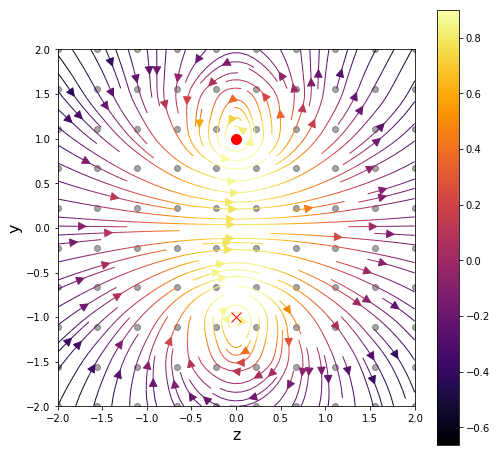

In [50]:
# Plot the magnetic field due to a loop here

### BEGIN SOLUTION
bfield_loop = calculate_bfield_from_current_elements(points_in_loop, 
                                                    yz_plane_points, 
                                                    clockwise_loop_wire_xy, dl=2*np.pi/n)

fig, ax1 = plt.subplots(1, figsize=(8,8))
magnitude_b_field = np.linalg.norm(bfield_loop,axis=0)

print(magnitude_b_field.shape)

color = np.log10(magnitude_b_field[0] )   # colors the arrows based on field strength

print(color.shape)

z_points_at_constant_x = yz_plane_points[2,0,:,:]
y_points_at_constant_x = yz_plane_points[1,0,:,:]

z_component_bfield = bfield_loop[2,0,:,:]
y_component_bfield = bfield_loop[1,0,:,:]

strm=ax1.streamplot(z_points_at_constant_x, y_points_at_constant_x, z_component_bfield, y_component_bfield, color=color, linewidth=1, 
               cmap=plt.cm.inferno, density=1.5, arrowstyle='simple', arrowsize=1.5)

plt.scatter(y_points_at_constant_x, z_points_at_constant_x, c='k', alpha=0.35) # Field points sampled

ax1.plot(0,1,'o', markersize=10, color='r')   # indicate the location of the wire

ax1.plot(0,-1,'x', markersize=10, color='r')   # indicate the location of the wire

fig.colorbar(strm.lines)

ax1.set_aspect('equal')
ax1.set_xlim([-2,2])
ax1.set_ylim([-2,2])
ax1.set_xlabel('z', fontsize=16)
ax1.set_ylabel('y', fontsize=16)
### END SOLUTION

Text(0,0.5,'y coords')

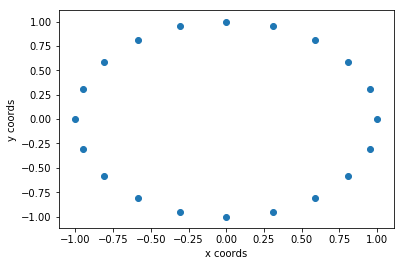

In [51]:
plt.scatter(points_in_loop[0].ravel(), points_in_loop[1].ravel())
plt.xlabel('x coords')
plt.ylabel('y coords')

### Helmholz coils (2 points)

You may have seen Helmholz coils in your lab class, a configuration of two parallel loops to produce a relatively uniform magnetic field in between the coils.  For one of your written homeworks, you wrote down an expression for $B(z)$ for two parallel circular loops with radius $R$, separated by a distance $a$. You can solve for $a$ such that $B(z)$ is uniform near the midpoint between the two coils. This means that you are looking for the value of $a$ that makes,
\begin{eqnarray}
\frac{d^2B}{dz^2}|_{z=0}&=&0
\end{eqnarray}
This is the case when $a=R$, so the coils are as far apart as the coil radius. Helmholz coils are meant to create a relatively uniform magnetic field in the region between the loops.

Set up Helmholz coils below, defining `points_in_parallel_loops` that sit at $z=\pm 0.5$, so $d=1=R$.

In [53]:
### BEGIN SOLUTION
# points_in_parallel_loops = np.array(np.meshgrid(np.cos(phi_vals),
#                                       np.sin(phi_vals),
#                                       np.array([0.5,-0.5]),
#                                         indexing='ij')
#   )

points_in_loop_top = np.array([np.cos(phi_vals),np.sin(phi_vals),0.5*np.ones(n)])
points_in_loop_top.resize((3,20,1,1))
points_in_loop_bottom = np.array([np.cos(phi_vals),np.sin(phi_vals),-0.5*np.ones(n)])
points_in_loop_bottom.resize((3,20,1,1))
points_in_parallel_loops = np.concatenate([points_in_loop_top, points_in_loop_bottom], axis=1)
print(points_in_parallel_loops.shape)

### END SOLUTION

(3, 40, 1, 1)


In [54]:
"""Execute to check you're on the right track"""
assert(points_in_parallel_loops.shape[0] == 3)
assert((points_in_parallel_loops >= -1).all() & (points_in_parallel_loops <= 1).all())
assert((np.abs(points_in_parallel_loops[2]) == 0.5).all())

**Plot** the magnetic field in the yz=plane.  Both loop currents go in the clockwise direction.

bfield vectors not summed shape:  (3, 1, 10, 10, 40, 1, 1)
with size:  12000
summed along fourth axis, bfield vectors shape:  (3, 1, 10, 10)
with size:  300
(1, 10, 10)
(10, 10)


Text(0,0.5,'y')

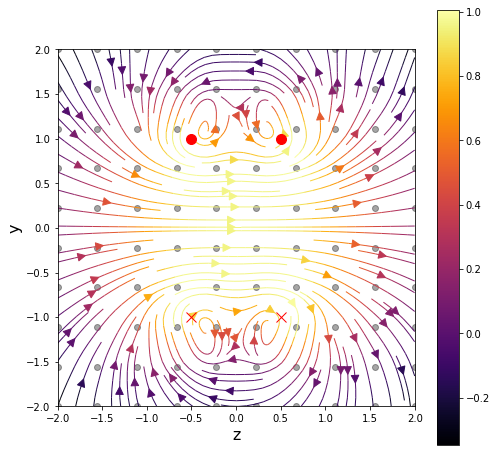

In [55]:
# Plot the magnetic field due to a helmholz coils here

### BEGIN SOLUTION
bfield_helmholz = calculate_bfield_from_current_elements(points_in_parallel_loops, 
                                                        yz_plane_points, 
                                                        clockwise_loop_wire_xy, dl=2*np.pi/n)

fig, ax1 = plt.subplots(1, figsize=(8,8))
magnitude_b_field = np.linalg.norm(bfield_helmholz,axis=0)
print(magnitude_b_field.shape)

color = np.log10(magnitude_b_field[0] )   # colors the arrows based on field strength

print(color.shape)

z_points_at_constant_x = yz_plane_points[2,0,:,:]
y_points_at_constant_x = yz_plane_points[1,0,:,:]

z_component_bfield = bfield_helmholz[2,0,:,:]
y_component_bfield = bfield_helmholz[1,0,:,:]

strm=ax1.streamplot(z_points_at_constant_x, y_points_at_constant_x, z_component_bfield, y_component_bfield, color=color, linewidth=1, 
               cmap=plt.cm.inferno, density=1.5, arrowstyle='simple', arrowsize=1.5)

plt.scatter(y_points_at_constant_x, z_points_at_constant_x, c='k', alpha=0.35) # Field points sampled

ax1.plot(0.5,1,'o', markersize=10, color='r')   # indicate the location of the wire
ax1.plot(0.5,-1,'x', markersize=10, color='r')   # indicate the location of the wire

ax1.plot(-0.5,1,'o', markersize=10, color='r')   # indicate the location of the wire
ax1.plot(-0.5,-1,'x', markersize=10, color='r')   # indicate the location of the wire


fig.colorbar(strm.lines)

ax1.set_aspect('equal')
ax1.set_xlim([-2,2])
ax1.set_ylim([-2,2])
ax1.set_xlabel('z', fontsize=16)
ax1.set_ylabel('y', fontsize=16)
### END SOLUTION
### END SOLUTION

**Plot (1 point):** 
- The magnitude of the magnetic field along the z-axis ($x,y=0$) through the axis of the coils.
- The magnitude of the magnetic field along the y-axis ($x,z=0$) in between the two coils.  

These are both 1-d regular line plots.   You can overplot on the same axis, but label the lines and add a legend.  You can first try using `magnitude_b_field` used to color-code your streamplot, but you will notice that you only have 10 points sampling along each axis.  You can see the full behavior by creating field points along the axis with higher resolution, e.g. `points_z_axis` and `points_y_axis`. 

*Note, from the plot I generated in my coded solution with 100 points sampling the axis, I suspect there is a bug in this notebook. If folks find a bug and can produce an expected plot with a bug fix, everyone in the class gets 10 extra credit points.  If I missed something else, there was an excuse to practice code review.* 

bfield vectors not summed shape:  (3, 1, 1, 100, 40, 1, 1)
with size:  12000
summed along fourth axis, bfield vectors shape:  (3, 1, 1, 100)
with size:  300
magz:  (1, 1, 100)
bfield vectors not summed shape:  (3, 1, 100, 1, 40, 1, 1)
with size:  12000
summed along fourth axis, bfield vectors shape:  (3, 1, 100, 1)
with size:  300
magy:  (1, 100, 1)


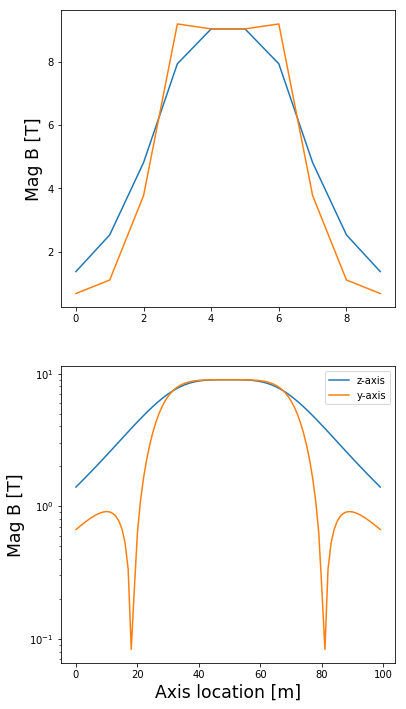

In [56]:
# Plot the magnitude of the magnetic field along the axes. 
### BEGIN SOLUTION
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(6,12))
ax1.plot(magnitude_b_field[0,5,:], label='z-axis')
ax1.plot(magnitude_b_field[0,:,5], label='y-axis')
ax1.set_ylabel('Mag B [T]',fontsize='xx-large')
points_z_axis = np.array(np.meshgrid(np.array([0]), np.array([0]), np.linspace(-2,2,100), indexing='ij'))
points_y_axis = np.array(np.meshgrid(np.array([0]), np.linspace(-2,2,100), np.array([0]), indexing='ij'))


bfield_z = calculate_bfield_from_current_elements(points_in_parallel_loops, 
                                                        points_z_axis, 
                                                        clockwise_loop_wire_xy, dl=2*np.pi/n)
magnitude_z = np.linalg.norm(bfield_z,axis=0)

print('magz: ',magnitude_z.shape)
bfield_y = calculate_bfield_from_current_elements(points_in_parallel_loops, 
                                                        points_y_axis, 
                                                        clockwise_loop_wire_xy, dl=2*np.pi/n)
magnitude_y = np.linalg.norm(bfield_y,axis=0)
print('magy: ',magnitude_y.shape)

ax2.plot(magnitude_z[0,0,:], label='z-axis')
ax2.plot(magnitude_y[0,:,0], label='y-axis')
ax2.set_ylabel('Mag B [T]',fontsize='xx-large')
ax2.set_xlabel('Axis location [m]',fontsize='xx-large')
ax2.legend()
ax2.set_yscale('log')
### END SOLUTION